# CP 2025-26: Q2 Lecture 3 - PDE (Part 1)

#### General Guidelines

> ⚠️⚠️⚠️ READ CAREFULLY ⚠️⚠️⚠️

- Do not add, delete or create cells, write the answer only in the space marked with the three dots (`...`). Where function skeletons are provided, it is assumed that that function can be called again with different inputs somewhere else. So be careful to write code outside of functions.
  - Function should be ['pure'](https://en.wikipedia.org/wiki/Pure_function), thus no side effects, unless otherwise specified.
- Run the the first cell to import all libraries when opening the notebook before running your own code.
- Read carefully what is required to be printed/returned/plotted in the answer. Please do not output what is not asked for. 
  - If you used the print function for debugging, comment it out ( Ctlr + / ) before submitting
- All plots should have title, xlabel, ylabel, and legend (if there are more than one curve on the plot)
- Use the `help()` function, consult python documentation when using new functions, or do a web search and consult [stackoverflow](https://stackoverflow.com/questions/tagged/python)
- Please read the error messages if you get any, and try to understand what they mean. Debugging code is an essential skill to develop.
- You can use `%debug` to start an IPython console in a cell (or a scratchpad cell!) after an exception has occurred to try to debug.
- You can use `%pdb` to toggle the Python DeBugger (pdb) auto start after an unhandled exception.
- In the assignments you will find some tests put in place, to help you verify your solution. If these fail you are certain you did something wrong, thus look at the hints they provide. But passing these tests does __not__ mean your solution is actually correct.

Make sure you use `python3.12` and the package versions as stated in the provided `requirements.txt`. This file should also be on the course page.

In [1]:
# Importing relevant libraries in the assignment

# This will create static plots (no zooming etc.)
# otherwise try just plain `%matplotlib`, or install a backend such as ipympl or PyQt5 and
# do or `%matplotlib ipympl` `%matplotlib qt`
%matplotlib inline

REPEAT_IMPORTS = True

if REPEAT_IMPORTS or ("IMPORTED_ALL" not in globals()):  # To save you a bit of time

    def print_import_info(package):
        print(
            "Successfully imported %-15s \tVersion: %10s"
            % (package.__name__, package.__version__)
        )

    #### Standard library imports

    import sys

    print("Python version {}".format(sys.version))
    if sys.version_info < (3, 12):
        print(
            "\u001b[31m"  # red
            "\u001b[1m"  # bold
            "WARNING: Use Python 3.12 or newer not to encounter any errors or problems later on. You can chance the the version. This sometime can be done by switching the kernel under the 'Kernel' tab."
            "\u001b[0m"  # reset
        )
    del sys  # Do not need it anymore

    #### Import third party libraries
    # Initialize self assessment helper
    import otter

    grader = otter.Notebook("Assignment_Q2_L3.ipynb")

    import numpy as np

    print_import_info(np)

    import numpy as np
    import scipy
    from scipy.sparse import lil_matrix
    from scipy.sparse.linalg import spsolve

    print_import_info(scipy)

    import matplotlib
    import matplotlib.pyplot as plt

    print_import_info(matplotlib)

    IMPORTED_ALL = True
    print("Finished importing packages")
else:
    print("Already imported all packages")

Python version 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Successfully imported numpy           	Version:      2.3.2
Successfully imported scipy           	Version:     1.16.1
Successfully imported matplotlib      	Version:     3.10.5
Finished importing packages


# Solving a Reaction-Diffusion Equation in Cylindrical Coordinates

### **Physical Description of the Problem**

In this exercise, we will solve the steady-state reaction-diffusion equation for a tubular reactor with convection. The reactor is cylindrical, and we consider both axial and radial dimensions. The tube wall is not permeable. The species $A$ undergoing the reaction diffuses radially, is convected axially by a flow, and reacts uniformly throughout the reactor volume.

#### Governing Equation

The governing equation in cylindrical coordinates is given as:

$$
u_z \frac{\partial C_A}{\partial z} = D \left( \frac{\partial^2 C_A}{\partial z^2} + \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial C_A}{\partial r} \right) \right) - k C_A
$$

Where:
- $ C_A $: Concentration of species A ($\mathrm{mol/m^3}$)
- $ u_z $: Axial velocity of the fluid ($\mathrm{m/s}$)
- $ D $: Diffusion coefficient ($\mathrm{m^2/s}$)
- $ k $: Reaction rate constant ($1/\mathrm{s}$)
- $ z $: Axial position ($\mathrm{m}$)
- $ r $: Radial position ($\mathrm{m}$)

#### Boundary Conditions
To model the reactor we consider half cylinder (symmetry), thus the domain in radial direction is $[0, R]$, with R the radius of the reactor in [$m$]. 

1. **Axial inlet ($z = 0$):**
   Dirichlet boundary condition with a given concentration $C_A = C_{A0}$ in a **specified radial fraction** of the inlet domain (this fraction represents the input nozzle to the reactor). Beyond this fraction, the concentration is zero. Note that this is a simplification in respect to the more rigorous approach considering the so-called *Danckwerts boundary condition*.

2. **Axial outlet ($z = L$):** 
  Consider what happens to the concentration gradient at the reactor outlet. Here, we can use the approach given by the *Danckwerts boundary condition*, which assumes zero variation: $\frac{\partial C_A}{\partial z} = 0$ (Neumann condition). This means that at the outlet, the concentration profile is fully developed and does not change further in the axial direction.

**You are required to define reasonable boundary conditions for the following boundaries:**
   
3. **Radial centerline ($r = 0$):** 
  **Hint:** Consider that we are modeling only half of the cylindrical reactor due to symmetry. At the centerline, the concentration profile must be symmetric - whatever happens on one side must be mirrored on the other side. Because of this symmetry, for every molecule moving from left to right across the centerline, there's an identical molecule moving from right to left. What kind of boundary condition can represent this physical behavior?
   
4. **Radial wall ($r = R$):** 
  **Hint:** Consider the physical nature of the reactor wall. Can species A pass through a solid reactor wall? What does this imply about the flux at this boundary and what boundary condition would represent this physical constraint.



### **Objective**

The goal is to solve this equation numerically using finite difference methods. You will discretize the governing equation, construct the system of linear equations $A \cdot C_A = b$, and solve for the concentration profile of species A in the reactor.


### **What You Need to Do**

**0. Formulate the required boundary conditions**
- See hints above.

**1. Discretization of the Equation**
- Use **central finite differences** for diffusion terms and **upwind scheme** for convective terms (*revise the upwind discretization scheme from Q1 - Lecture 6*).
- Use **ghost points** around the domain boundaries requiring Neumann type BC and use a discretization scheme with second-order accuracy.
- Assemble the coefficient matrix $A$ and the right-hand-side (RHS) vector $b$ for the linear system. The system should consist of $(N_z \times N_r)$ unknowns.
- **Hints**:
  - Hint #1: discretize the PDE and write the system on paper first! 
  - Hint #2: Consider to expand the cylindrical diffusion term (i.e., using the chain rule to expand the second order derivative in radial direction) to simplify the discretization

**2. Implement the Solver**
- Solve the resulting system of linear equations $A \cdot C = b$ using a numerical solver.

**3. Visualize the Results**
- Reshape the solution vector $C$ into a 2D array corresponding to the reactor geometry ($z$ and $r$).
- Plot:
  - The 2D concentration profile of species A in the reactor.
  - Radial concentration profiles at different axial positions.


#### **Parameters and Specifications**

- **Reactor Geometry:**
  - Length ($L$): $1.0 \, \mathrm{m}$
  - Radius ($R$): $0.1 \, \mathrm{m}$

- **Species Properties:**
  - Diffusion coefficient ($D$): $0.2 \times 10^{-3} \, \mathrm{m^2/s}$
  - Reaction rate constant ($k$): $0.001 \, \mathrm{s^{-1}}$

- **Flow Properties:**
  - Axial velocity ($u_z$): $0.5 \, \mathrm{m/s}$

- **Boundary Conditions:**
  - Inlet concentration ($C_{A0}$): $1.0 \, \mathrm{mol/m^3}$
  - Fraction of the radial domain at the inlet with concentration specified: $0.5$

- **Grid Parameters:**
  - Number of grid points in the axial direction ($N_z$): $100$
  - Number of grid points in the radial direction ($N_r$): $100$

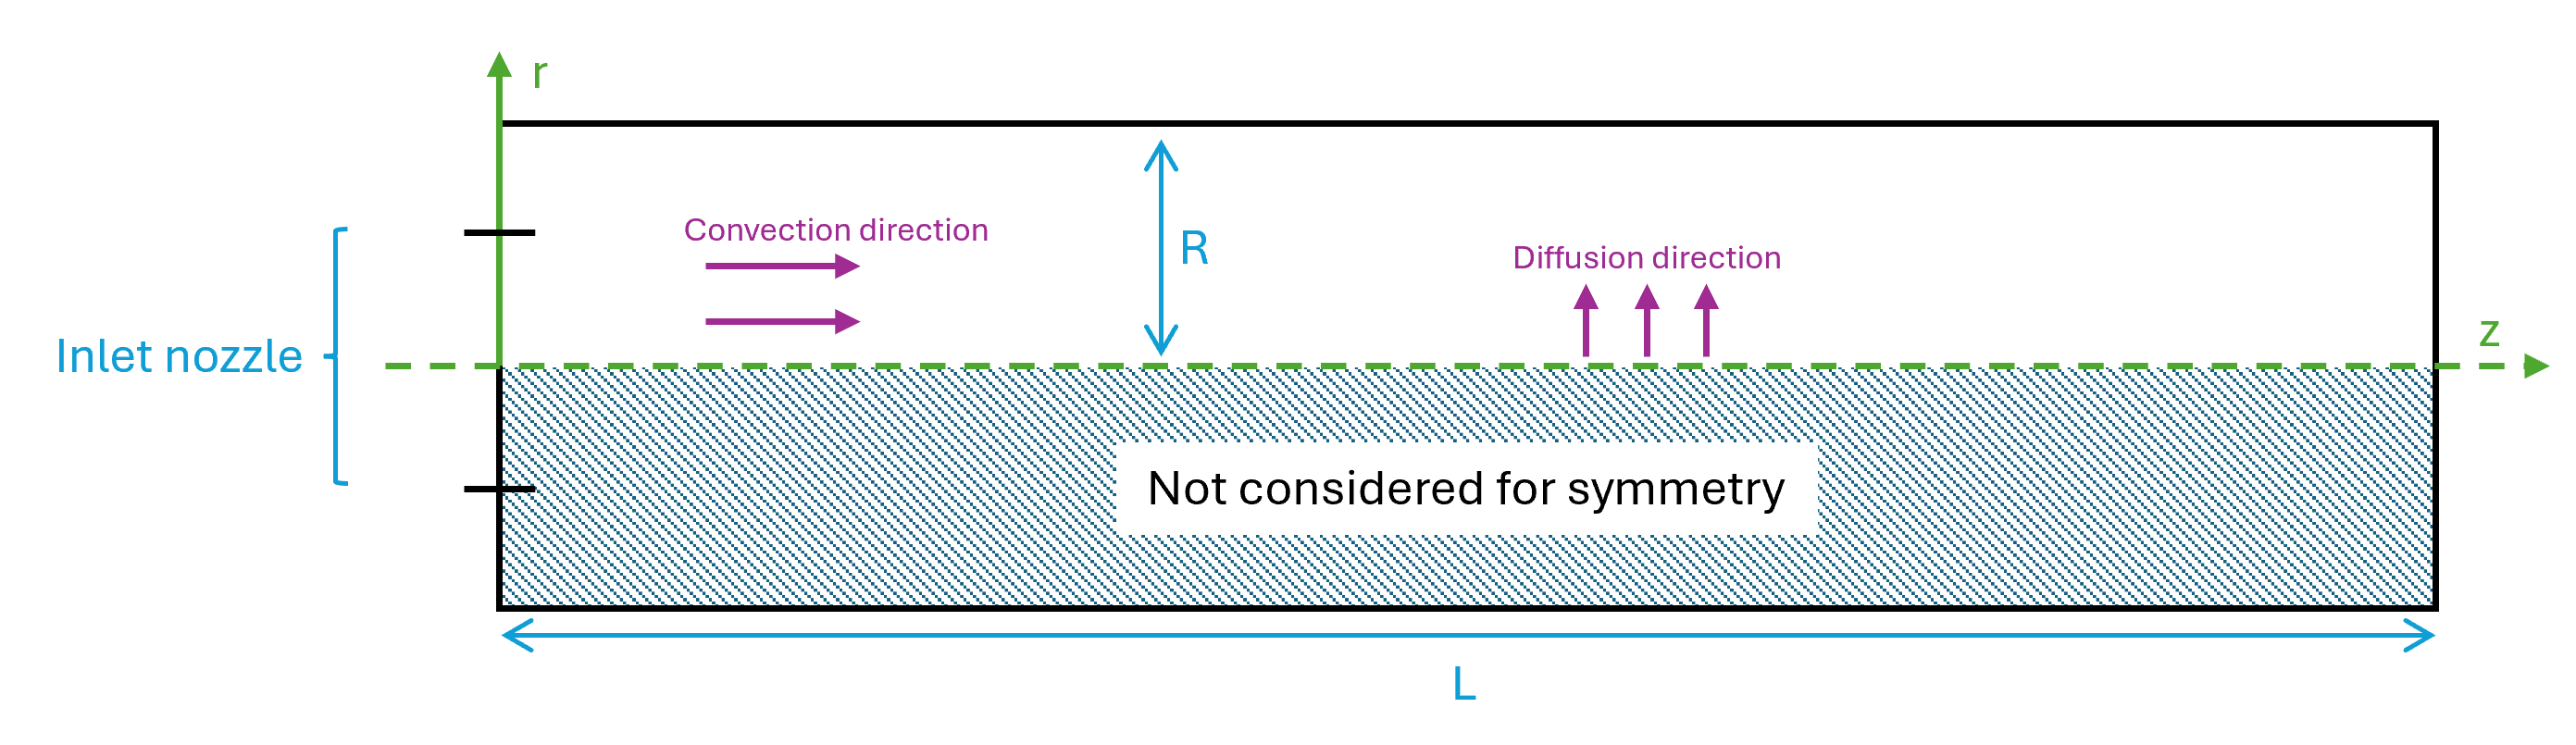


### **Implementation Steps**

**Step 1: Write a Function to Build the Coefficient Matrix $A$**
- Write a function that creates the coefficient matrix $A$ for the discretized equation.

**Step 2: Write a Function to Build the RHS Vector $b$**
- Implement a function that constructs the RHS vector $b$, applying the Dirichlet boundary condition at the inlet.

**Step 3: Solve the Linear System**
- Use an efficient sparse matrix solver to solve $A \cdot C = b$.

**Step 4: Visualize the Results**
- Reshape the solution vector $C$ into a 2D array corresponding to the reactor geometry ($z$ and $r$).
- Plot: (*already implemented*)
  1. A 2D contour plot of $C_A$ over the reactor geometry.
  2. Radial profiles of $C_A$ at multiple axial positions.

#### Use sparse matrix definition and solver

In this exercise, we use sparse matrices to efficiently handle the large, mostly zero-filled coefficient matrix $A$ that arises from the discretization of the reaction-diffusion equation. Sparse matrices are preferred in such cases to save memory and improve computational performance.

**Sparse Matrix Definition**

We use the `lil_matrix` class from the `scipy.sparse` module to define the coefficient matrix $A$. The `lil_matrix` (List of Lists) format is particularly suited for constructing matrices incrementally, as it allows efficient row-based modifications. Once the matrix is fully assembled, it is converted to the CSR (Compressed Sparse Row) format for efficient arithmetic operations and solving.

Relevant documentation:
- [`scipy.sparse.lil_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)
- [`scipy.sparse.csr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)

**Sparse Solver**

The sparse linear system $A \cdot C = b$ is solved using the `spsolve` function from the `scipy.sparse.linalg` module. This function efficiently solves sparse linear systems by leveraging the sparsity of $A$, leading to faster computation times compared to dense solvers.

Relevant documentation:
- [`scipy.sparse.linalg.spsolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html)

**Workflow**
1. Define the matrix $A$ using `lil_matrix` to populate the coefficients.
2. Convert $A$ to CSR format using `.tocsr()` for efficient solving.
3. Solve $A \cdot C = b$ using `spsolve`.

This approach is ideal for handling large systems typical of finite-difference discretization in multidimensional domains.

**Hint: Remember always that division by zero can be avoided by adding numerically negligible small numbers ($\epsilon$)**

In [2]:
"""
the following is a example pseudo-code from slide: 45
"""

# from scipy.sparse import lil_matrix 
# A = lil_matrix((100,100))

# for j in range(10):
#     for i in range(10):
#         n = i+ j * 10
#         A[n,n] = 1
#         A[n,]
# print(A.toarray())

'\nthe following is a example pseudo-code from slide: 45\n'

## Boundary conditions
 1) **Dirichlet**: $C_A(z = 0) = C_{A0}$ (LHS)
 2) **Neumann**: $\frac{\delta C_a}{\delta z} (z = L) = 0$ (RHS)
 3) **Neumann**: $\frac{\delta C_a}{\delta r} (r = 0) = 0$  
 4) **Neumann**: $\frac{\delta C_a}{\delta r} (r = R) = 0$ 

In [10]:

""" 
    This following approach is from the example exercise, however one cannot use this approach as it requires you to have diagonal uniformity. In this case your diffusion 1/r_i term breaks this uniformity and changes with every i itteration. Therefore it is easier to uses lil_matrix to solve this more efficiently. """
    # # number of unknows
    # N = (N_z-2)*(N_r-2)

    # # laplace operators from finite difference method           # might be wrong because its missing a 1/2 but look at this after
    # L = (u_z/dz + D/dz**2)                      # Left 
    # R = (D/dz**2)                               # Right
    # O = (-D/(r*dr) + D/dr**2)                   # Lower
    # U = (D/(r*dr) + D/dr**2)                    # Upper
    # D = (-u_z/dz - 2*D/dz**2 - 2*D/dr**2)       # Diagonal 

    # # the main diagonal
    # main_diagonal = np.full(N,D)

    # # off diagonals
    # off_diag_L_vals = np.full(N-1, L)
    # off_diag_R_vals = np.full(N-1, R)
    # off_diag_O_vals = np.full(N-(N_r-2), O)
    # off_diag_U_vals = np.full(N-(N_r-2), U)

    # # adjust for the boundary conditions:
    # for j in range(1,N_r):
    #     idx = j*(N_z-2)-1
    #     off_diag_L_vals[idx] = 0
    #     off_diag_R_vals[idx] = 0

    # diag = [
    #     main_diagonal,
    #     off_diag_L_vals,
    #     off_diag_R_vals,
    #     off_diag_O_vals,
    #     off_diag_U_vals
    # ]
    # offsets = [0,-1,1,-(N_z-2), N_z-2]

    # A = scipy.sparse.diag(diag, offsets, shape=(N,N), format = "csr")

    # # implement the boundaries   

print(np.zeros((10,5)))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
def build_poisson_matrix(
    N_z: int,
    N_r: int,
    dz: float,
    dr: float,
    u_z: float,
    D: float,
    k: float,
    r: np.ndarray,
) -> lil_matrix:
    """
    Builds the coefficient matrix A for the discretized reaction-diffusion equation.

    Parameters:
        N_z (int): Number of grid points in the axial direction.
        N_r (int): Number of grid points in the radial direction.
        dz (float): Grid spacing in the axial direction.
        dr (float): Grid spacing in the radial direction.
        u_z (float): Axial convective velocity.
        D (float): Diffusion coefficient.
        k (float): Reaction rate constant.
        r (np.ndarray): Radial positions.

    Returns:
        A (lil_matrix): Coefficient matrix A.
    """
    # define the number of points 
    N = N_z * N_r                               # notice that the number of points is not (N_z - 2) * (N_r-2), this is becasue we are including the boundaries inside of the A matrix

    A = lil_matrix((N, N))                      # lil_matrix is a flexible builder, it is a "list of lists" sparse matrix. This means before solving you need to compress it to a sparse row; ie. : A_csr = A.tocsr()

    for j in range(N_r):                        # itterating the raidial coordinates 
        for i in range(N_z):                    # itterating the axial coordinates
            n = i + j * N_z                     # this is to move between the individual 'subsystems' which are each a distance of N_z appart

            # define the dirichlet boundary condition: CA(z=0) = CA0 --> if i == 0 then A[n,n] = 1. This creates and 'identity subsystem' for the whole first r 'subsystem'
            if i == 0:
                A[n,n] = 1
                continue                                    # the continue is important as otherwise when adding all the points to the matrix, the first 'subsystem' would have its values rewritten 

            # since we are deviding by r, and r is an array from [0,R], there are point where we might be deviding by zero. To avoid this, if r[j]=0 we can make it a very small number to avoid the devision by zero
            r_j = r[j] if r[j] != 0 else 1e-6

            # define the Laplacian operators using the finite difference method, this was done on paper 
            L = (u_z/dz + D/dz**2)                          # Left 
            R = (D/dz**2)                                   # Right
            O = (-D/(2*r_j*dr) + D/dr**2)                       # Lower                 # the 1/2 term arrises from x[i+1]-x[i-1] (this is 2dx)
            U = (D/(2*r_j*dr) + D/dr**2)                        # Upper
            diag = (-u_z/dz - 2*D/dz**2 - 2*D/dr**2 - k)        # Diagonal 

            # define the boundary conditions (2) - (4) as BC(1) was already set
            if i == N_z-1:
                L += R          # BC(2):
                R = 0           # make sure that the other side is then always set to zero so that it is not being added twice
                 
            if j == 0:
                U += O          # BC(3):
                O = 0
            
            if j == N_r-1:
                O += U           # BC(4):
                U = 0

            # add all the points to the matrix, since the boundary conditions were already changed for each i and j itteration, the addition of the boundary points and interior points can be done at once 
            # the if conditions are added so that the code doesnt attempt to add values outside of the defined matrix
            # this can be cuased by a line such as A[n,n+N_z] = U, if valid for any n, then the right boundary it will attempt to add R U to n+nz which is out of bounds

            A[n,n] = diag
            if i>0:
                A[n,n-1] = L
            if i<N_z-1:
                A[n,n+1] = R
            if j>0:
                A[n, n-N_z] = O
            if j<N_r-1:
                A[n, n+N_z] = U


    # A = A.tocsr()             # dont do this here, the wanted output is a lil_matrix
    return A


In [14]:
grader.check("q1")

q1 results: All test cases passed!

In [ ]:
def build_rhs_vector(
    N_z: int, N_r: int, C_A0: float, inlet_fraction: float
) -> np.ndarray:
    """
    Builds the RHS vector b for the discretized reaction-diffusion equation.

    Parameters:
        N_z (int): Number of grid points in the axial direction.
        N_r (int): Number of grid points in the radial direction.
        C_A0 (float): Inlet concentration.
        inlet_fraction (float): Fraction of radial domain at the inlet where concentration is specified.

    Returns:
        b (np.ndarray): RHS vector b.
    """
    """
    What do I know:
        - I know that the first sub-matrix (n = 1) is an identity matrix because of the dirichlet bc where C(z=0) = CA0
            However it was mentioned that: CA = CA0 in a specified radial frction of the inlet domain (this fraction represent the input nozzle to the reactor)
            Therefore CA = CA0 only when r < inlet_fraction * R
        - All other point however in the b matrix should be equal to zero
    """
   
    # number of points
    N = N_z * N_r                   # remeber that the number of points in the poisson matrix is N_z*N_r and the b vector must match that 

    b = np.zeros(N)
    
    j_cutoff = int(N_r * inlet_fraction)        # notice that the inlet_fraction is a fraction of the number of points, not the fraction of the radius 

    for j in range(0,N_r):   
        n = 0 + j*N_z               # this come from the submatricies, where i must be zero (inlet condition z=0)
        if j<j_cutoff:
            b[n] = C_A0 
    
    return b 

In [34]:
grader.check("q2")

q2 results: All test cases passed!

In [37]:
def solve_system(A: lil_matrix, b: np.ndarray) -> np.ndarray:
    A = A.tocsr()   # remember that the A matrix was left in lil_matrix form becasue of the grader 
    sol = scipy.sparse.linalg.spsolve(A,b)
    return sol

In [40]:
# Parameters
L = 1.0  # Reactor length (m)
R = 0.1  # Reactor radius (m)
D = 0.2e-3  # Diffusion coefficient (m^2/s)
k = 0.001  # Reaction rate constant (1/s)
C_A0 = 1.0  # Inlet concentration (mol/m^3)
u_z = 0.5  # Axial convective velocity (m/s)

# Inlet conditions
inlet_fraction = (
    0.5  # Fraction of radial domain at the inlet where concentration is specified
)

# Grid parameters
N_z = 100  # Number of grid points in z-direction (axial)
N_r = 100  # Number of grid points in r-direction (radial)

# discretize the points
z = np.linspace(0,L,N_z)
r = np.linspace(0,R,N_r)

# find the difference
dz = z[1]- z[0]
dr = r[1] - r[0]

A = build_poisson_matrix(N_z, N_r, dz, dr, u_z, D, k, r)
b = build_rhs_vector(N_z, N_r, C_A0, inlet_fraction)

# Solve the linear system
C = solve_system(A, b)

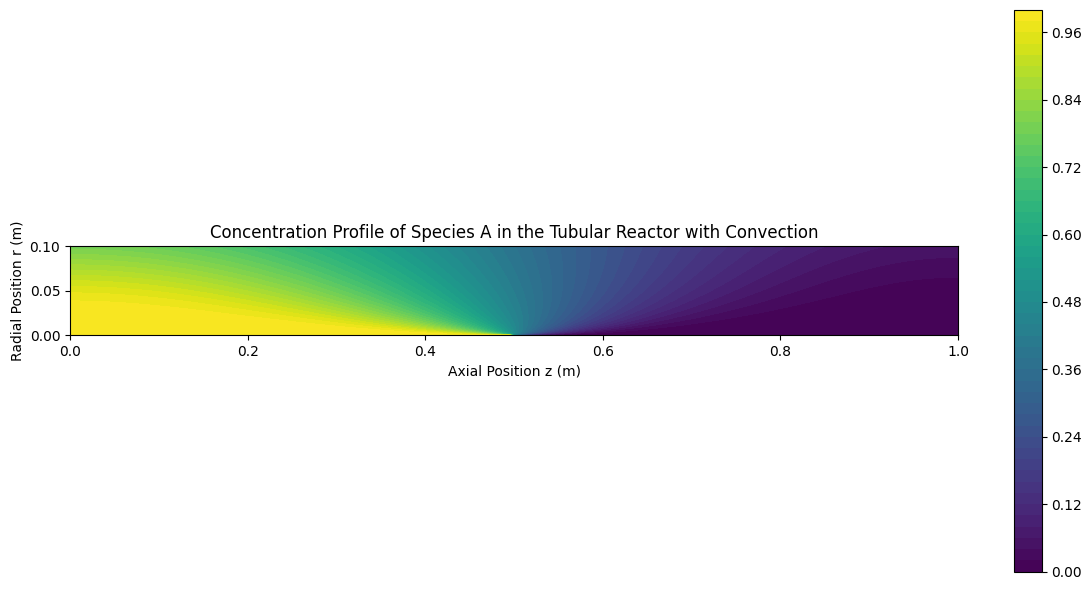

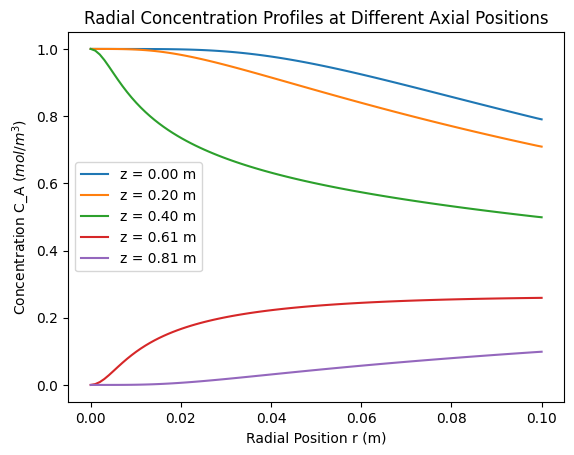

In [41]:
# Reshape the solution vector into a 2D array for plotting
C_A = C.reshape((N_r, N_z))

# Generate meshgrid for plotting
Z, R_grid = np.meshgrid(z, r, indexing="ij")  # Use 'ij' indexing

# Plot the concentration profile with actual dimensions
plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization
cp = plt.contourf(Z, R_grid, C_A, levels=50, cmap="viridis")
plt.colorbar(cp)
plt.title("Concentration Profile of Species A in the Tubular Reactor with Convection")
plt.xlabel("Axial Position z (m)")
plt.ylabel("Radial Position r (m)")

# Ensure the correct aspect ratio
ax = plt.gca()
ax.set_aspect(
    L / R, adjustable="datalim"
)  # Set aspect ratio based on reactor dimensions
plt.axis("scaled")  # Ensures equal scaling
plt.tight_layout()
plt.show()

# Plot radial concentration profiles at different axial positions
plt.figure()
for i in range(0, N_z, int(N_z / 5)):
    plt.plot(r, C_A[i, :], label=f"z = {z[i]:.2f} m")
plt.xlabel("Radial Position r (m)")
plt.ylabel("Concentration C_A ($mol/m^3$)")
plt.title("Radial Concentration Profiles at Different Axial Positions")
plt.legend()
plt.show()

In [42]:
grader.check("q3")

q3 results: All test cases passed!

### Reflect on the results
Do you think the simulation is physically realistic at the inlet section $z=0$? Can you propose a more physically accurate approach to handle the domain boundary at $z=0$?

*Insert your answer here*